In [403]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# II Part - Critic's reviews

In [316]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/gabaslava/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gabaslava/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#opening the scraped critic's reviews:
review_and_outcome = pd.read_csv('review_and_outcome_clean.csv').values

## Perform word tokenization and lemmatization

In [186]:
#tokenizing the review texts:

text = [i[0] for i in review_and_outcome if pd.notnull(i[0])] 
outcome = [i[1] for i in review_and_outcome if pd.notnull(i[0])]

stop_words = set(stopwords.words('english'))
stop_words.update(['youve', 'theyve', 'shouldnt', 'theyll', 'werent', 'hadnt', 'everyones'])

Lem = WordNetLemmatizer()


tokenized_text = []
for i in text:
    t1 = word_tokenize(i) #separating all the words into separate strings
    t2 = [w.lower() for w in t1] #converting to lower-case
    t3 = [w for w in t2 if w.isalpha()] #remove all elements that are not alpahbetical
    t4 = [w for w in t3 if not w in stop_words] #eliminating stop-words
    t0 = [Lem.lemmatize(w) for w in t4]
    tokenized_text.append(t0)
    
#getting rid of the the texts that have 200 words and less
X=[]
Y=[]
# eliminates 87reviews that don't meet the threshold
for i,e in zip(tokenized_text,outcome):
    if len(i)>200:
        X.append(i)
        Y.append(e)

### Sample now consists of 2132 reviews: 1114 categorized as True and 1018 as False

In [187]:
Counter(Y)

Counter({False: 1018, True: 1114})

### Longest review has of 5615 lemmatized words , shortest - 202 words.
### On average review has 477 words with standard deviation of 229.
### Total word count(non unique) for all reviews combined is over 1M.

In [190]:
max_len = max([len(i) for i in X])
min_len = min([len(i) for i in X])
mean_x = np.mean([len(i) for i in X])
std_x = np.std([len(i) for i in X])
total_x = sum([len(i) for i in X]) #total word count/non-unique

max_len, min_len, mean_x, std_x, total_x 

(5615, 202, 477.1735459662289, 229.19951837893814, 1017334)

### Converting strings of words into vectors with Word2Vec model from gensim.
#### Vector dimentionality size will be 100, meaning each unique word will be represented with a vector of 100 numbers. After the model was applied, it was discovered that there were 44,874 unique words in the corpora.

In [191]:
import gensim

model=gensim.models.Word2Vec(sentences=X, size=100, window=5, min_count=1) 
model.train(X, total_examples=len(X), epochs=7) 
unique_words=list(model.wv.vocab) 
len(unique_words) 

44874

## Checking what words have similar vectorization to words 'human', 'politics' or 'profound'
### The meaning of words is in context of the critic reviews. Seems like words represented as vectors make more or less some sense

In [194]:
model.wv.most_similar('human'), model.wv.most_similar('profound'), model.wv.most_similar('politics')

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


([('being', 0.8176770210266113),
  ('humanity', 0.7718660831451416),
  ('nature', 0.7668523788452148),
  ('condition', 0.7571300268173218),
  ('individual', 0.7566896677017212),
  ('guiltlessly', 0.7230907678604126),
  ('primitiveness', 0.7149591445922852),
  ('philosophic', 0.7124838829040527),
  ('survival', 0.7110925316810608),
  ('inner', 0.7050951719284058)],
 [('philosophical', 0.9263257384300232),
  ('inherent', 0.9221957325935364),
  ('irony', 0.9196577072143555),
  ('purely', 0.9182047843933105),
  ('intellectual', 0.9125933647155762),
  ('core', 0.9122554063796997),
  ('underlying', 0.9102522134780884),
  ('truthful', 0.9080044627189636),
  ('confronting', 0.9078915119171143),
  ('whodunit', 0.9043021202087402)],
 [('parable', 0.8589251637458801),
  ('notion', 0.8467729091644287),
  ('economic', 0.8455523252487183),
  ('religious', 0.8399254083633423),
  ('racial', 0.8370649218559265),
  ('knowledge', 0.8362333178520203),
  ('wreaks', 0.8349178433418274),
  ('philosophy', 0.8

In [195]:
#saving the the word-vectors:
filename = 'gensim_word2vec.csv'
model.wv.save_word2vec_format(filename, binary=False)

In [196]:
#creating a dictionary of words and their vectors
def word_and_vec(vectors_file):
    embeddings = {}
    f = open(vectors_file)
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings[word] = vector
    f.close()
    return embeddings

word_embeddings = word_and_vec('gensim_word2vec.csv')


### Now vectorizing the texts. 


In [197]:
#mapping vectors to words in the text:
def sentences_vectorized(sentences, embeddings, vec_dim, unique_word_emb):
    vectorized_corpora=[]
    for review,i in zip(sentences,range(len(sentences))):
        vectorized_reveiew = np.array([embeddings[word] for word in review if word in unique_word_emb]) 
        vectorized_corpora.append(np.array(vectorized_reveiew))
    return vectorized_corpora

vectorized_text_corpora = sentences_vectorized(X, word_embeddings, 100, unique_words)

In [198]:
len(vectorized_text_corpora)
#that's 2132 samples, each review represented by 100D vector

2132

### Separating words from positive sentiment reviews and negative sentiment word vectors.
#### Those separated lists consist of 544,596 word-vectors that were in reviews marked as True and 472,738 word-vectors that were in reviews marked False


In [202]:
def separate_true_false_review_words(vectorized_sentences, outcome):
    word_vectors_true = []
    word_vectors_false = []   
    for i,e in zip(vectorized_sentences,outcome):
        for word in i:
            if all(np.array(word)!=0):
                if e==True:
                    word_vectors_true.append(word)
                elif e==False:
                    word_vectors_false.append(word)
    return word_vectors_true, word_vectors_false


word_vectors_true, word_vectors_false = separate_true_false_review_words(vectorized_text_corpora, Y)

len(word_vectors_true), len(word_vectors_false)   

(544596, 472738)

## Reducing vector dimentionality with t-distributed stochastic neighbor embedding and visualising the vectors in 2D to find out if they form some kind of clusters:

In [204]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random

In [205]:
tsne= TSNE(n_components=2, perplexity=40, n_iter=500)

#since original sample sizes are to big for t-sne, let's randomly select around 9% of the population
true_sample = random.sample(word_vectors_true, 47000)
tsne_results_true = tsne.fit_transform(true_sample)
false_sample = random.sample(word_vectors_false, 47000)
tsne_results_false = tsne.fit_transform(false_sample)

### Clusters in the below image are intertwined however clearly perceptible. This is expected as the whole text corpus was taken into consideration, i.e. there is a great deal of words that are repeated both in negative sentiment reviews and also in positive.
#### Next step is reducing the dimentionality with principal component analysis before applying TSNE

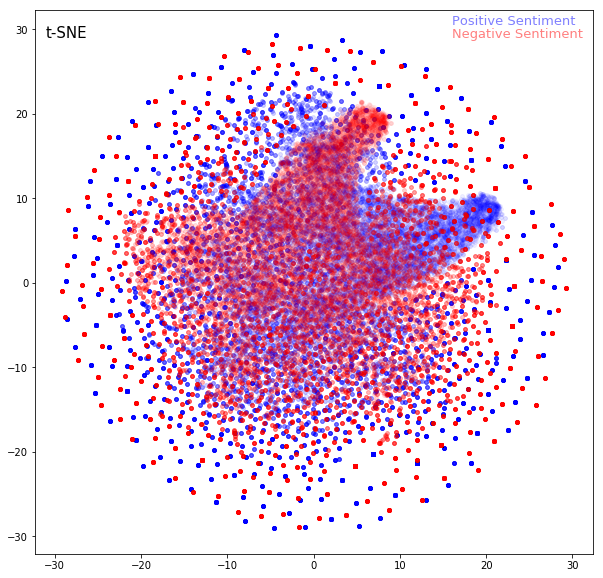

In [207]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter([i[0] for i in tsne_results_true], [i[1] for i in tsne_results_true], 
            s=15, c='b', marker="o", alpha=0.06)
ax1.scatter([i[0] for i in tsne_results_false], [i[1] for i in tsne_results_false], 
            s=15, c='r', marker="o", alpha=0.06)
ax1.text(-31, 29, 't-SNE', fontsize=15)
ax1.text(16, 30.5, 'Positive Sentiment', color='b', fontsize=13, alpha=0.5)
ax1.text(16, 29, 'Negative Sentiment', color='r', fontsize=13, alpha=0.5);

### Creating a visual using PCA for reducing the 100 dimentions to 30. And then applying TSNE on principal components.


In [ ]:
#reducing the 100dimentions to 30:
pca_true = PCA(n_components=30).fit_transform(true_sample)
pca_false = PCA(n_components=30).fit_transform(false_sample)
#applying tSNE:
tsne= TSNE(n_components=2, perplexity=40, n_iter=500)
tsne_results_true2 = tsne.fit_transform(pca_true)
tsne_results_false2 = tsne.fit_transform(pca_false)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter([i[0] for i in tsne_results_true2], [i[1] for i in tsne_results_true2], 
            s=15, c='b', marker="o", alpha=0.06)
ax1.scatter([i[0] for i in tsne_results_false2], [i[1] for i in tsne_results_false2], 
            s=15, c='r', marker="o", alpha=0.06)
ax1.text(-32, 31, 'PCA + t-SNE', fontsize=15)
ax1.text(16, 31, 'Positive Sentiment', color='b', fontsize=13, alpha=0.5)
ax1.text(16, 29, 'Negative Sentiment', color='r', fontsize=13, alpha=0.5);

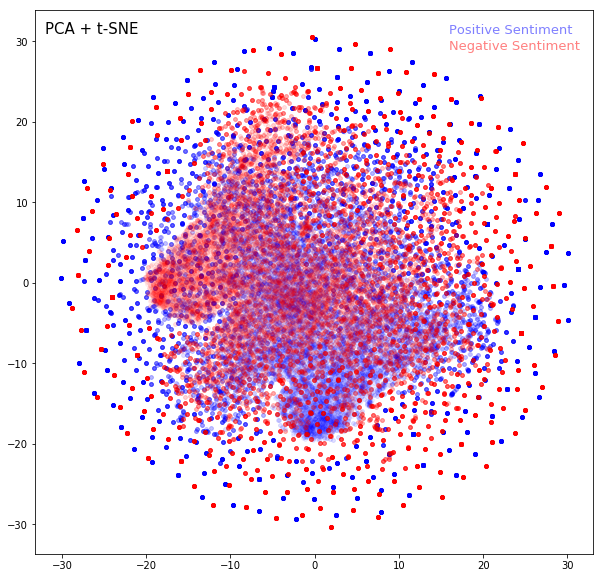

In [129]:
#reducing the 100dimentions to 30:
pca_true = PCA(n_components=30).fit_transform(true_sample)
pca_false = PCA(n_components=30).fit_transform(false_sample)
#applying tSNE:
tsne= TSNE(n_components=2, perplexity=40, n_iter=500)
tsne_results_true2 = tsne.fit_transform(pca_true)
tsne_results_false2 = tsne.fit_transform(pca_false)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter([i[0] for i in tsne_results_true2], [i[1] for i in tsne_results_true2], 
            s=15, c='b', marker="o", alpha=0.06)
ax1.scatter([i[0] for i in tsne_results_false2], [i[1] for i in tsne_results_false2], 
            s=15, c='r', marker="o", alpha=0.06)
ax1.text(-32, 31, 'PCA + t-SNE', fontsize=15)
ax1.text(16, 31, 'Positive Sentiment', color='b', fontsize=13, alpha=0.5)
ax1.text(16, 29, 'Negative Sentiment', color='r', fontsize=13, alpha=0.5);



## Creating dataframes of unique words and their count for true and false outcome. Visualization of these unique words will tell if different words are represented accurately after dimention reduction

### There is 34,342 unique word in True outcome, and 32,507 words in False

In [208]:
X_true=[]
X_false=[]
for i,e in zip(X,Y):
    if e == True:
        X_true += i
    elif e == False:
        X_false += i
true_unique =  pd.DataFrame.from_dict(Counter(X_true), orient='index').reset_index().sort_values(by=[0], ascending=False)
false_unique = pd.DataFrame.from_dict(Counter(X_false), orient='index').reset_index().sort_values(by=[0], ascending=False)
len(true_unique), len(false_unique) 

(34342, 32507)

### Extracting top 3000 words for each outcome and of those taking only the ones that are exclusively belonging to either one of the categories.
### Each category has 500words that are most common for their own outcome and at the same time not as common in the opposite outcome. Word frequency for the top 3000 words is between 6011 and 28

In [209]:
top3000_true = list(true_unique[:3000]['index'].values)
top3000_false = list(false_unique[:3000]['index'].values)
exp_true_in_top3000 = [i for i in top3000_true if i not in top3000_false]
exp_false_in_top3000 = [i for i in top3000_false if i not in top3000_true]

len(exp_true_in_top3000), len(exp_false_in_top3000)

(500, 500)

In [210]:
print('True words repetition between: %d and %d times. \nFalse words repetition between: %d and %d times.' % 
     (max(true_unique[:3000][0]), min(true_unique[:3000][0]),
      max(false_unique[:3000][0]), min(false_unique[:3000][0])))

True words repetition between: 6011 and 32 times. 
False words repetition between: 5057 and 28 times.


## Vectorizing the most common words in their explicit outcome:

In [211]:
def words_vectorized(words, embeddings, vec_dim, unique_word_emb):
    vectorized_words=np.zeros((len(words), vec_dim)) 
    for w,i in zip(words,range(len(words))):
        if w in unique_word_emb:
            vectorized_words[i] = embeddings[w]
        else:
            vectorized_words[i] = np.zeros(50)
    return vectorized_words

exp_true_vectors = words_vectorized(exp_true_in_top3000, word_embeddings, 100, unique_words)
exp_false_vectors = words_vectorized(exp_false_in_top3000, word_embeddings, 100, unique_words)

## Reducing dimentions with both PCA and tSNE and visualising the words from different outcomes
### from the two graphs it is clear that using tSNE the true/false words separate slightly better. Though some reduced dimention words are clashing in 2D it is only normal considering that the words can have similar meaning, i.e. similar vector representation as well  

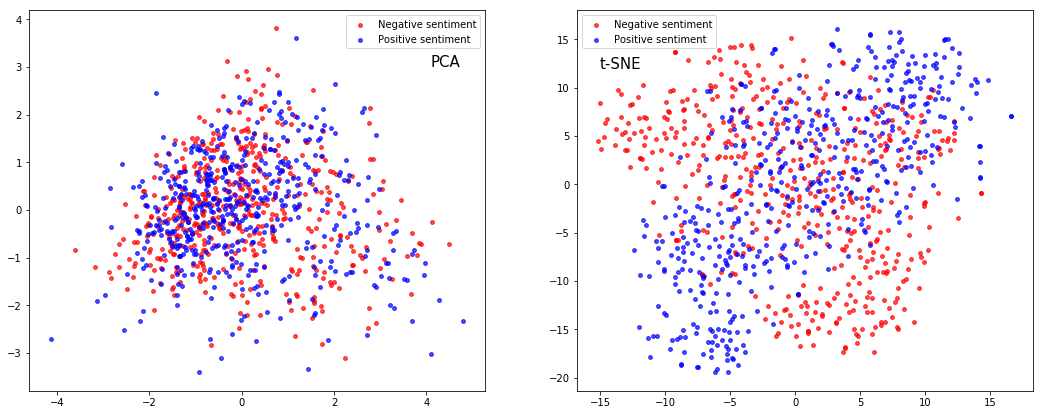

In [218]:
pca_true_exp = PCA(n_components=2).fit_transform(exp_true_vectors)
pca_false_exp = PCA(n_components=2).fit_transform(exp_false_vectors)

tsne = TSNE(n_components=2, perplexity=40, n_iter=500)
tsne_true_exp = tsne.fit_transform(exp_true_vectors)
tsne_false_exp = tsne.fit_transform(exp_false_vectors)

fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter([i[0] for i in pca_false_exp], [i[1] for i in pca_false_exp], 
            s=15, c='r', marker="o", label='Negative sentiment', alpha=0.7)
ax1.scatter([i[0] for i in pca_true_exp], [i[1] for i in pca_true_exp], 
            s=15, c='b', marker="o", label='Positive sentiment', alpha=0.7)
ax1.text(4.1, 3, 'PCA', fontsize=15)
ax1.legend()
ax2.scatter([i[0] for i in tsne_false_exp], [i[1] for i in tsne_false_exp], 
            s=15, c='r', marker="o", label='Negative sentiment', alpha=0.7)
ax2.scatter([i[0] for i in tsne_true_exp], [i[1] for i in tsne_true_exp], 
            s=15, c='b', marker="o", label='Positive sentiment', alpha=0.7)
ax2.text(-15, 12, 't-SNE', fontsize=15)
ax2.legend();

## Extracting the words for each outcome that are occuring between 32 and 10 times explicitly for the outcome.
### Each category has 1741words that are relatively common for their own outcome and at the same time not belonging in the frequency group of the opposite outcome 
### Relatively common words are more specific for the outcome compared to the top3000 most frequent. And by vectorization also seem to have different meanings when comparing the outcomes

In [219]:
middle4000_true = list(true_unique[3000:7000]['index'].values)
middle4000_false = list(false_unique[3000:7000]['index'].values)
exp_true_in_middle4000 = [i for i in middle4000_true if i not in middle4000_false]
exp_false_in_middle4000 = [i for i in middle4000_false if i not in middle4000_true]

exp_middle_true_vectors = words_vectorized(exp_true_in_middle4000, word_embeddings, 100, unique_words)
exp_middle_false_vectors = words_vectorized(exp_false_in_middle4000, word_embeddings, 100, unique_words)

len(exp_middle_true_vectors), len(exp_middle_false_vectors)

(1741, 1741)

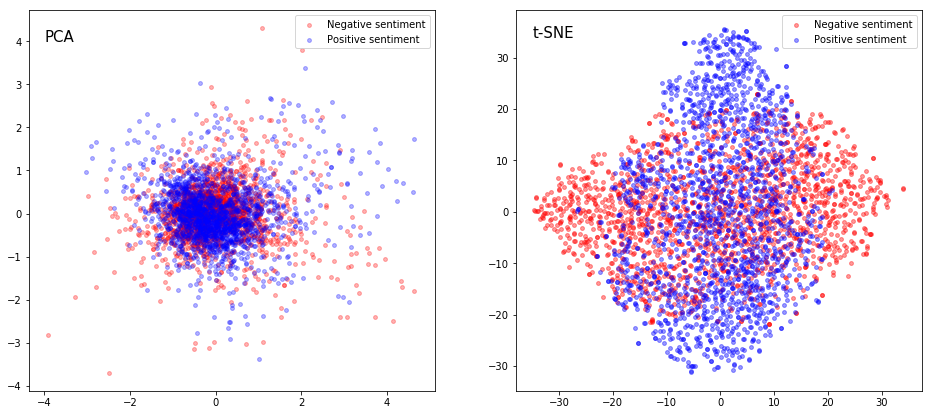

In [248]:
pca_true_exp_middle = PCA(n_components=2).fit_transform(exp_middle_true_vectors)
pca_false_exp_middle = PCA(n_components=2).fit_transform(exp_middle_false_vectors)

tsne = TSNE(n_components=2, perplexity=40, n_iter=500)
tsne_true_exp_middle = tsne.fit_transform(exp_middle_true_vectors)
tsne_false_exp_middle = tsne.fit_transform(exp_middle_false_vectors)

fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter([i[0] for i in pca_false_exp_middle], [i[1] for i in pca_false_exp_middle], 
            s=15, c='r', marker="o", label='Negative sentiment', alpha=0.3)
ax1.scatter([i[0] for i in pca_true_exp_middle], [i[1] for i in pca_true_exp_middle], 
            s=15, c='b', marker="o", label='Positive sentiment', alpha=0.3)
ax1.text(-4, 4, 'PCA', fontsize=15)
ax1.legend()
ax2.scatter([i[0] for i in tsne_false_exp_middle], [i[1] for i in tsne_false_exp_middle], 
            s=15, c='r', marker="o", label='Negative sentiment', alpha=0.4)
ax2.scatter([i[0] for i in tsne_true_exp_middle], [i[1] for i in tsne_true_exp_middle], 
            s=15, c='b', marker="o", label='Positive sentiment', alpha=0.4)
ax2.text(-35, 34, 't-SNE', fontsize=15)
ax2.legend();

## Extracting the words for each outcome that are occuring between 11 and 3 times explicitly for the outcome.
### Each category has 4470 words that are specific for their own outcome and at the same time not belonging in the frequency group of the opposite outcome 
### Considering less common words, True and False outcome share only 55percent of the words that appear between 11 and 3 times, meaning less common words are more attached to the outcome. 
### Based on reduced dimention vectors, seems like words have even more separation in regards of their meaning, at this point even PCA distinguished some sort of split between True and Flase outcome.

In [248]:
lessfrequent8000_true = list(true_unique[7000:15000]['index'].values)
lessfrequent8000_false = list(false_unique[7000:15000]['index'].values)
exp_true_in_lessfrequent8000 = [i for i in lessfrequent8000_true if i not in lessfrequent8000_false]
exp_false_in_lessfrequent8000 = [i for i in lessfrequent8000_false if i not in lessfrequent8000_true]

exp_bottom_true_vectors = words_vectorized(exp_true_in_lessfrequent8000, word_embeddings, 100, unique_words)
exp_bottom_false_vectors = words_vectorized(exp_false_in_lessfrequent8000, word_embeddings, 100, unique_words)

len(exp_bottom_true_vectors), len(exp_bottom_false_vectors)

(4470, 4470)

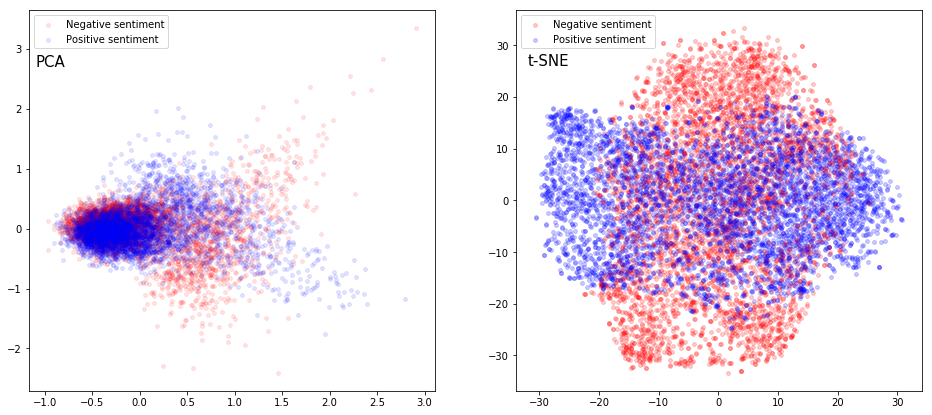

In [261]:
pca_true_exp_bottom = PCA(n_components=2).fit_transform(exp_bottom_true_vectors)
pca_false_exp_bottom = PCA(n_components=2).fit_transform(exp_bottom_false_vectors)

tsne = TSNE(n_components=2, perplexity=40, n_iter=500)
tsne_true_exp_bottom = tsne.fit_transform(exp_bottom_true_vectors)
tsne_false_exp_bottom = tsne.fit_transform(exp_bottom_false_vectors)

fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter([i[0] for i in pca_false_exp_bottom], [i[1] for i in pca_false_exp_bottom], 
            s=15, c='r', marker="o", label='Negative sentiment', alpha=0.1)
ax1.scatter([i[0] for i in pca_true_exp_bottom], [i[1] for i in pca_true_exp_bottom], 
            s=15, c='b', marker="o", label='Positive sentiment', alpha=0.1)
ax1.text(-1.1, 2.7, 'PCA', fontsize=15)
ax1.legend()
ax2.scatter([i[0] for i in tsne_false_exp_bottom], [i[1] for i in tsne_false_exp_bottom], 
            s=15, c='r', marker="o", label='Negative sentiment', alpha=0.2)
ax2.scatter([i[0] for i in tsne_true_exp_bottom], [i[1] for i in tsne_true_exp_bottom], 
            s=15, c='b', marker="o", label='Positive sentiment', alpha=0.2)
ax2.text(-32, 26, 't-SNE', fontsize=15)
ax2.legend();

# Using GloVe pre-trained embedding 
### GloVe is Stanford University pre-trained word embedding with a dictionary of 400K unique words. Pre-trained word vectors downloaded from: https://nlp.stanford.edu/projects/glove/

In [225]:
file = "glove.6B.50d.txt" #word embeddings - 50D vectors
def loadGloveModel(File):
    with open(File, encoding="utf8" ) as f:
        content = f.readlines()
    word_embeddings = {}
    for line in content:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        word_embeddings[word] = embedding
    print (len(word_embeddings)," words loaded")
    return word_embeddings
     
glove_embedding = loadGloveModel(file)
glove_unique_words = list(glove_embedding.keys()) 


400000  words loaded


### Embedding the reviews with GloVe vectors gets a total of 538,048 words in True outcome reviews, and 467,229 words in False

In [226]:
glove_vectorized_sentences = sentences_vectorized(X, glove_embedding, 50, glove_unique_words)
glove_words_true, glove_words_false = separate_true_false_review_words(glove_vectorized_sentences, Y)

In [227]:
len(glove_words_true), len(glove_words_false) 

(538048, 467229)

## TSNE for GloVe embedded text

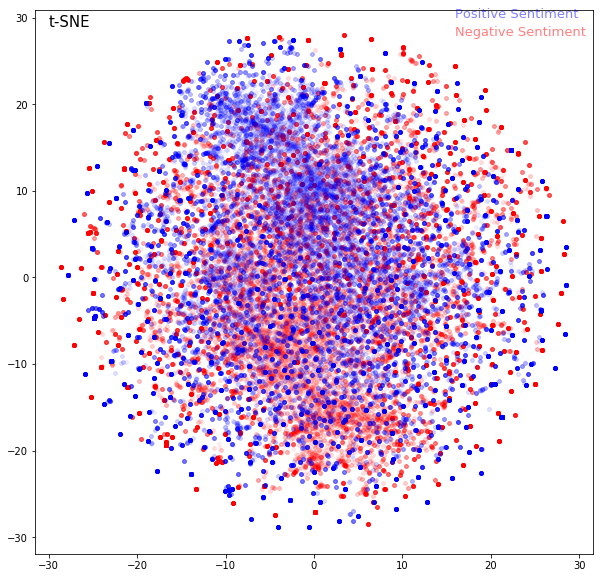

In [228]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=500)

#get sample
glove_true_sample = random.sample(glove_words_true, 45000)
glove_false_sample = random.sample(glove_words_false, 45000)

glove_tsne_sample_true = tsne.fit_transform(glove_true_sample)
glove_tsne_sample_false = tsne.fit_transform(glove_false_sample)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter([i[0] for i in glove_tsne_sample_true], [i[1] for i in glove_tsne_sample_true], 
            s=15, c='r', marker="o", alpha=0.06)
ax1.scatter([i[0] for i in glove_tsne_sample_false], [i[1] for i in glove_tsne_sample_false], 
            s=15, c='b', marker="o", alpha=0.06)
ax1.text(16, 30, 'Positive Sentiment', color='b', fontsize=13, alpha=0.5)
ax1.text(16, 28, 'Negative Sentiment', color='r', fontsize=13, alpha=0.5)
ax1.text(-30, 29, 't-SNE', fontsize=15);

## Visualising only the uniquely most common words, vectorized with GloVe embedding:
### It seems like GloVe model might be more appropriate word embedding solution as the vizualization shows more separation between True and False outcome words

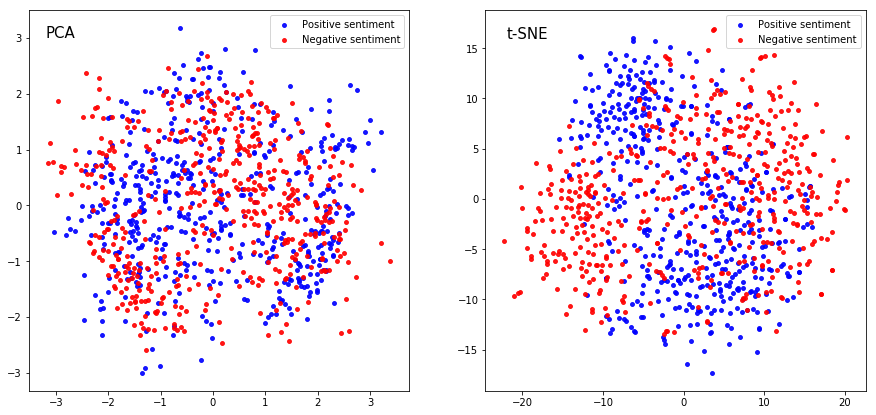

In [235]:
exp_true_glove_vectors = words_vectorized(exp_true_in_top3000, glove_embedding, 50, glove_unique_words)
exp_false_glove_vectors = words_vectorized(exp_false_in_top3000, glove_embedding, 50, glove_unique_words)
#Principal componens model:
glove_pca_true_exp = PCA(n_components=2).fit_transform(exp_true_glove_vectors)
glove_pca_false_exp = PCA(n_components=2).fit_transform(exp_false_glove_vectors)
#tSNE model:
tsne = TSNE(n_components=2, perplexity=40, n_iter=500)
glove_tsne_exp_true = tsne.fit_transform(exp_true_glove_vectors)
glove_tsne_exp_false = tsne.fit_transform(exp_false_glove_vectors)

fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter([i[0] for i in glove_pca_true_exp], [i[1] for i in glove_pca_true_exp], 
            s=15, c='b', marker="o", label='Positive sentiment', alpha=0.9)
ax1.scatter([i[0] for i in glove_pca_false_exp], [i[1] for i in glove_pca_false_exp], 
            s=15, c='r', marker="o", label='Negative sentiment', alpha=0.9)
ax1.text(-3.2, 3, 'PCA', fontsize=15);
ax1.legend()
ax2.scatter([i[0] for i in glove_tsne_exp_true], [i[1] for i in glove_tsne_exp_true], 
            s=15, c='b', marker="o", label='Positive sentiment', alpha=0.9)
ax2.scatter([i[0] for i in glove_tsne_exp_false], [i[1] for i in glove_tsne_exp_false], 
            s=15, c='r', marker="o", label='Negative sentiment', alpha=0.9)
ax2.text(-22, 16, 't-SNE', fontsize=15);
ax2.legend();



## Visualising the words of moderate frequency that are uniquely attached to the outcome, vectorized with GloVe embedding:

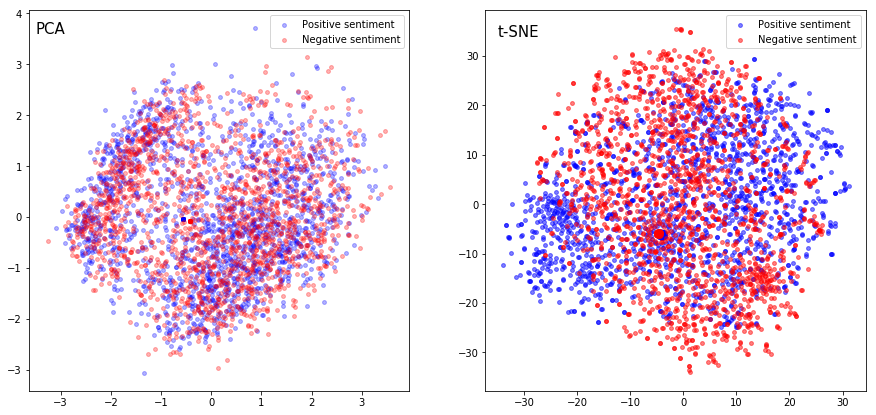

In [245]:
middle_true_glove_vectors = words_vectorized(exp_true_in_middle4000, glove_embedding, 50, glove_unique_words)
middle_false_glove_vectors = words_vectorized(exp_false_in_middle4000, glove_embedding, 50, glove_unique_words)
#Principal componens model:
glove_pca_true_middle = PCA(n_components=2).fit_transform(middle_true_glove_vectors)
glove_pca_false_middle = PCA(n_components=2).fit_transform(middle_false_glove_vectors)
#tSNE model:
tsne = TSNE(n_components=2, perplexity=40, n_iter=500)
glove_tsne_true_middle = tsne.fit_transform(middle_true_glove_vectors)
glove_tsne_false_middle = tsne.fit_transform(middle_false_glove_vectors)

fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter([i[0] for i in glove_pca_true_middle], [i[1] for i in glove_pca_true_middle], 
            s=15, c='b', marker="o", label='Positive sentiment', alpha=0.3)
ax1.scatter([i[0] for i in glove_pca_false_middle], [i[1] for i in glove_pca_false_middle], 
            s=15, c='r', marker="o", label='Negative sentiment', alpha=0.3)
ax1.text(-3.5, 3.6, 'PCA', fontsize=15);
ax1.legend()
ax2.scatter([i[0] for i in glove_tsne_true_middle], [i[1] for i in glove_tsne_true_middle], 
            s=15, c='b', marker="o", label='Positive sentiment', alpha=0.5)
ax2.scatter([i[0] for i in glove_tsne_false_middle], [i[1] for i in glove_tsne_false_middle], 
            s=15, c='r', marker="o", label='Negative sentiment', alpha=0.5)
ax2.text(-35, 34, 't-SNE', fontsize=15);
ax2.legend();



## Visualising the words of low frequency that are uniquely attached to the outcome, vectorized with GloVe embedding:

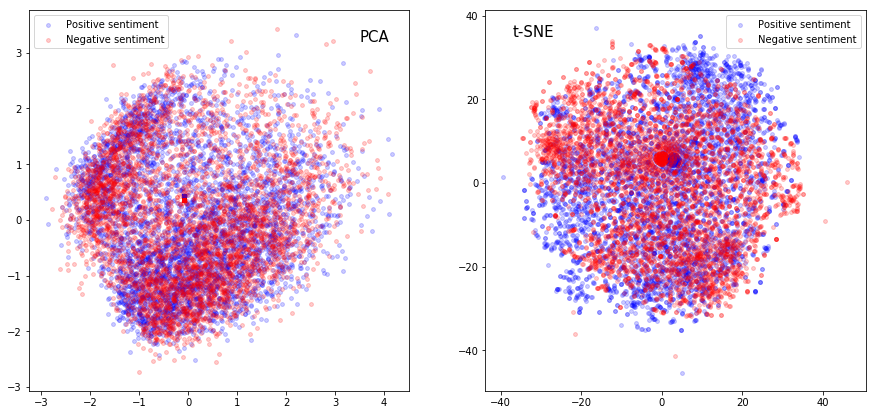

In [269]:
bottom_true_glove_vectors = words_vectorized(exp_true_in_lessfrequent8000, glove_embedding, 50, glove_unique_words)
bottom_false_glove_vectors = words_vectorized(exp_false_in_lessfrequent8000, glove_embedding, 50, glove_unique_words)
#Principal componens model:
glove_pca_true_bottom = PCA(n_components=2).fit_transform(bottom_true_glove_vectors)
glove_pca_false_bottom = PCA(n_components=2).fit_transform(bottom_false_glove_vectors)
#tSNE model:
tsne = TSNE(n_components=2, perplexity=40, n_iter=500)
glove_tsne_true_bottom = tsne.fit_transform(bottom_true_glove_vectors)
glove_tsne_false_bottom = tsne.fit_transform(bottom_false_glove_vectors)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter([i[0] for i in glove_pca_true_bottom], [i[1] for i in glove_pca_true_bottom], 
            s=15, c='b', marker="o", label='Positive sentiment', alpha=0.2)
ax1.scatter([i[0] for i in glove_pca_false_bottom], [i[1] for i in glove_pca_false_bottom], 
            s=15, c='r', marker="o", label='Negative sentiment', alpha=0.2)
ax1.text(3.5, 3.2, 'PCA', fontsize=15);
ax1.legend()
ax2.scatter([i[0] for i in glove_tsne_true_bottom], [i[1] for i in glove_tsne_true_bottom], 
            s=15, c='b', marker="o", label='Positive sentiment', alpha=0.2)
ax2.scatter([i[0] for i in glove_tsne_false_bottom], [i[1] for i in glove_tsne_false_bottom], 
            s=15, c='r', marker="o", label='Negative sentiment', alpha=0.2)
ax2.text(-37, 35, 't-SNE', fontsize=15);
ax2.legend();

#### based on the visuals, word2vec word embedding might separate the classes better than GloVe

# Applying Bag of Words model using sklearn's CountVectorizer to convert reviews into matrixes of unique word counts and preparing to fit the data on a Logistic Regression model

### Each sample text will be represented as a sparse matrix shaped (2132, 44851). The rows being length of sample size(there are 2132 reviews) and columns being unique word count. Each word found by the analyzer during the fit is assigned a unique integer index corresponding to a column in the resulting matrix.

In [270]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

#the data fed to CountVectorizer has to be represented as joined text
#one_hot representation of outcome will be applied for training a neural network 
X_texts = [' '.join(i) for i in X] 
Y_onehot = np.eye(2)[np.array(Y).astype(int)]

vectorizer = CountVectorizer()
vectorizer.fit(X_texts)
X_asvectors = vectorizer.transform(X_texts)

# Issue with this approach is that long texts have much more impact than short texts because they have more words so the matrixes have more weight. 
# To eliminate this issue, each word will be divided by total word count in the specific sample.
tfidf = TfidfTransformer()
X_tfidf_vectors = tfidf.fit_transform(X_asvectors)

print(X_tfidf_vectors.shape)


X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf_vectors, np.array(Y).astype(int), test_size=0.2, random_state=98)
X_train_neur, X_test_neur, Y_train_neur, Y_test_neur = train_test_split(X_tfidf_vectors, Y_onehot, test_size=0.2, random_state=98)

(2132, 44851)


### Based solely on the words being used in the reviews, Logistic regression algorithm can distinguish positive sentiment from negative sentiment with 80% accuracy

In [274]:
from sklearn.linear_model import LogisticRegression


log_classifier = LogisticRegression()
log_classifier.fit(X_train, Y_train)
acc = log_classifier.score(X_test, Y_test) *100
print('Accuracy score for test sample is %.1f%% ' % round(acc,1))

Accuracy score for test sample is 80.1% 


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Using Support Vector Machines algorithm the classification is even better - 84%

In [272]:
svc_classifier = SVC(kernel='linear', gamma='auto')  
svc_classifier.fit(X_train, Y_train)
acc_svc = svc_classifier.score(X_test, Y_test) *100
print('Accuracy score for test sample is %.1f%% ' % round(acc_svc,1))


Accuracy score for test sample is 84.5% 


### Building a Neural Network with keras, categorization can be achieved with 87% accuracy

In [275]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

In [296]:
input_dim = X_train_neur.shape[1]  # Number of features

model = Sequential()
model.add(Dense(20, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train_neur, Y_train_neur, epochs=40, batch_size=55, validation_data=(X_test_neur, Y_test_neur))



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 20)                897040    
_________________________________________________________________
dropout_26 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 2)                 42        
Total params: 897,082
Trainable params: 897,082
Non-trainable params: 0
_________________________________________________________________
Train on 1705 samples, validate on 427 samples
Epoch 1/40
1705/1705 [==============================] - 7s 4ms/step - loss: 0.6882 - acc: 0.5361 - val_loss: 0.6806 - val_acc: 0.5410
Epoch 2/40
1705/1705 [==============================] - 3s 1ms/step - loss: 0.6471 - acc: 0.6868 - val_loss: 0.6548 - val_acc: 0.6885
Epoch 3/40
1705/1705 [==============================] - 3s 1ms/step - loss: 0.5646 - 

### Training accuracy and loss versus validation accuracy and loss during the 40 learning epochs plotted

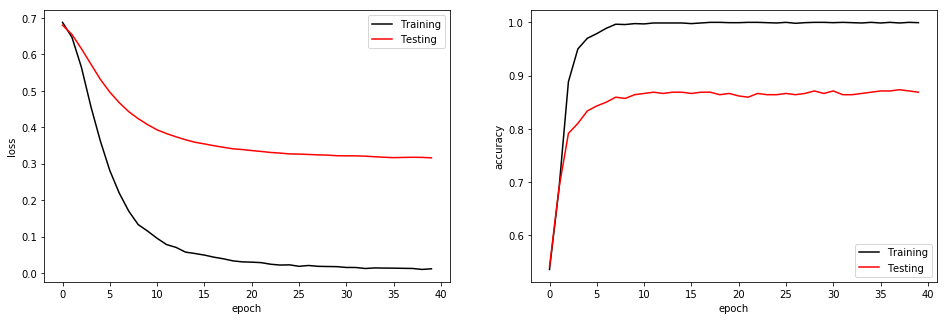

In [297]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(history.epoch, history.history['loss'], c='k', label='Training')
ax1.plot(history.epoch, history.history['val_loss'], c='r', label='Testing')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(history.epoch, history.history['acc'], c='k', label='Training')
ax2.plot(history.epoch, history.history['val_acc'], c='r', label='Testing')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend();


### Positive sentiment is predicted with more accuracy than Negative sentiment: 

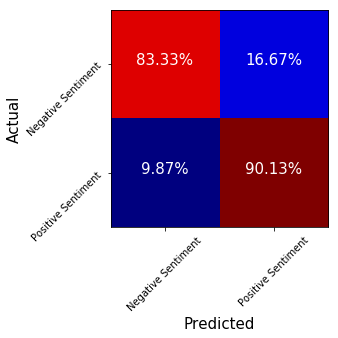

In [451]:
import itertools
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_test_neur)
matri=confusion_matrix(Y_test_neur.argmax(axis=1), predictions.argmax(axis=1))
normalized_matrix=matri/matri.sum(axis=1)[:, np.newaxis] *100
plt.imshow(normalized_matrix, cmap=plt.cm.jet, )
plt.xticks([0,1], ['Negative Sentiment','Positive Sentiment'], rotation=45)
plt.yticks([0,1], ['Negative Sentiment','Positive Sentiment'], rotation=45)
for i, j in itertools.product(range(normalized_matrix.shape[0]), range(normalized_matrix.shape[1])):
    plt.text(j, i, (format(normalized_matrix[i, j], '.2f')+'%'), horizontalalignment="center", size=15, color='w')
plt.xlabel('Predicted', size=15)
plt.ylabel('Actual', size=15);

### Model is making correct predictions with more confidence:

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


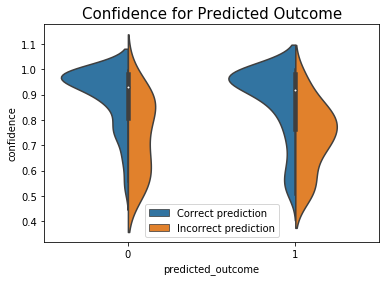

In [454]:
import seaborn as sns
#function extracting predicted outcome and the confidence from softmax
def pred_confidence(y_predicted, y_test):
    real = np.argmax(y_test, axis=1)
    pred = np.argmax(y_predicted, axis=1)
    prob = np.max(y_predicted, axis=1)
    accuracy=[]
    for i in range(len(real)):
        if real[i]==pred[i]:
            accuracy.append('Correct prediction')
        else:
            accuracy.append('Incorrect prediction')
    return pd.DataFrame({'predicted_outcome': pred, 'confidence': prob, 'accurate':accuracy})

confid = pred_confidence(predictions, Y_test_neur)

p=sns.violinplot('predicted_outcome', 'confidence', data=confid, hue='accurate', split=True)
p.legend(loc='lower center')
plt.title('Confidence for Predicted Outcome', size=15);
